In [1]:
import pandas as pd
import scipy as sc
from scipy.cluster.hierarchy import ward, dendrogram
import numpy as np
import re
import nltk
from nltk.collocations import *
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Смотрим на датасет

In [2]:
dfemails = pd.read_csv("./datasets/hillary-clinton-emails/Emails.csv")
dfreceivers = pd.read_csv("./datasets/hillary-clinton-emails/EmailReceivers.csv")

In [3]:
dfemails[:2]

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...


Наибольший интерес представляет сам текст письма, его можно получить из поля "ExtractedBodyText" или попробовать самому руками выделить из "RawText". Кажется, что лучше, чем в "ExtractedBodyText" не получится, поэтому попробуем взять егго :)

In [4]:
dfemails[:1]["RawText"][0].split("\n")

['UNCLASSIFIED',
 'U.S. Department of State',
 'Case No. F-2015-04841',
 'Doc No. C05739545',
 'Date: 05/13/2015',
 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.',
 'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.',
 'RELEASE IN FULL',
 'From: Sullivan, Jacob J <Sullivan11@state.gov>',
 'Sent: Wednesday, September 12, 2012 10:16 AM',
 'To:',
 'Subject: FW: Wow',
 'From: Brose, Christian (Armed Services) (mailto:Christian_Brose@armed-servic,essenate.govi',
 'Sent: Wednesday, September 12, 2012 10:09 AM',
 'To: Sullivan, Jacob J',
 'Subject: Wow',
 'What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me',
 'too',
 'UNCLASSIFIED',
 'U.S. Department of State',
 'Case No. F-2015-04841',
 'Doc No. C05739545',
 'Date: 05/13/2015',
 'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.',
 'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER. STATE-5CB0045247',
 '\x0c']

In [5]:
for i in dfemails[:5]["ExtractedBodyText"]:
    print(str(i) + "\n")

nan

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary

Thx

nan

H <hrod17@clintonemail.com>
Friday, March 11, 2011 1:36 PM
Huma Abedin
Fw: H: Latest: How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx
Pis print.



In [6]:
for i in dfemails[:5]["ExtractedSubject"]:
    print(str(i) + "\n")

FW: Wow

nan

Re: Chris Stevens

FVV: Cairo Condemnation - Final

nan



### Вырезаем то, что нам интересно

Заметим, что текст, отправитель и получатели иногда отсутствует, поправим это

In [7]:
print(dfemails.shape)

dfemails = dfemails.dropna(subset=['SenderPersonId', 'ExtractedSubject', 'ExtractedBodyText'])

print(dfemails.shape)

(7945, 22)
(5414, 22)


В письмах интереснее всего (для восприятия человеком), кто написал, кому и что. Попробуем составить датасет с такими колонками "from", "to", "text", "subject"

In [8]:
cutTrashFromSubject = lambda subject: str(subject).lower().replace("re:", "").replace("fvv:", "").replace("fwd:", "").replace("fw:", "").replace("h:", "").strip()

In [9]:
df = pd.DataFrame({'from': dfemails["SenderPersonId"],
                   'to': [" ".join(map(str, dfreceivers.loc[dfreceivers["EmailId"] == emailId]["PersonId"])) for emailId in dfemails["Id"]],
                   'subject': [cutTrashFromSubject(subject) for subject in dfemails["ExtractedSubject"]], 
                   'text': dfemails["ExtractedBodyText"]})

In [10]:
df[:5]

,from,subject,text,to
2,32.0,chris stevens,Thx,228 80
5,80.0,meet the right wing extremist behind anti-musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,185
8,87.0,secretary's remarks,FYI,80
10,87.0,abz and hb3 on libya and west bank/gaza,Fyi\nB6\n— —,80
12,87.0,hey,Fyi,80


In [11]:
df['from'] = df['from'].astype(int)
df[:5]

,from,subject,text,to
2,32,chris stevens,Thx,228 80
5,80,meet the right wing extremist behind anti-musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,185
8,87,secretary's remarks,FYI,80
10,87,abz and hb3 on libya and west bank/gaza,Fyi\nB6\n— —,80
12,87,hey,Fyi,80


Теперь все верно

### Найдем самые частые биграммы

In [12]:
vectorizer = CountVectorizer(ngram_range = (2, 2), stop_words = 'english', min_df = 10)
X = vectorizer.fit_transform(df['text'])

Добавили stop_words = 'english', потому что иначе топ из частот биграм был полон прелогов с артиклями: to the, for the и т д

Теперь найдем топ-10 биграм

In [13]:
bigramFreq = list(zip(vectorizer.get_feature_names(), np.asarray(X.sum(axis=0)).ravel()))
bigramFreq.sort(key = lambda t: t[1], reverse = True)

bigramFreq[:10]

[('secretary office', 368),
 ('00 pm', 344),
 ('state department', 344),
 ('united states', 339),
 ('white house', 294),
 ('30 pm', 261),
 ('en route', 249),
 ('department state', 227),
 ('pm secretary', 215),
 ('secretary state', 189)]

### NLTK

Вспомогательная функция, которой нет в Python 3 :(

In [14]:
flatten = lambda l: [item for sublist in l for item in sublist]

Парсим предложения их каждого письма и затеи парсим их на слова с помощью NLTK

In [15]:
nltk.download('punkt')
tokenizedSent = [sent_tokenize(emailText) for emailText in df['text']]
tokenizedWords = [word_tokenize(tokenizedSent) for tokenizedSent in flatten(tokenizedSent)]
tokenizedWords[:2]

[nltk_data] Downloading package punkt to /Users/Alexander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['Thx'], ['Pis', 'print', '.']]

In [16]:
bigramMeasures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(tokenizedWords)
finder.nbest(bigramMeasures.pmi, 10)

[("'1.com", 'aeirig'),
 ("'1HE", ".i't"),
 ("'Banish", 'Sexual'),
 ("'Li", 'Matou'),
 ("'bad", 'talkers'),
 ("'badly", "trained'"),
 ("'civ", 'cas'),
 ("'i1", '.CRAl'),
 ('***Happy', 'BIrthday'),
 ('*Haitian-Am', 'ofessor')]

Результат немного странный :) Возможно стоит подумать над тем, как почистить тексты

### Кластеризация

In [17]:
tfIdfVectorizer = TfidfVectorizer(max_df=500, min_df=10)
matrix = tfIdfVectorizer.fit_transform(df['text'])

In [18]:
matrix.shape

(5414, 3129)

In [19]:
clusterCount = 7

In [20]:
# тут можно идти пить чай
model = AgglomerativeClustering(n_clusters = clusterCount, affinity = 'euclidean', linkage = 'complete')
clusterPredictions = model.fit_predict(matrix.toarray())

In [21]:
clusterPredictions[:30]

array([1, 2, 3, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 3, 1,
       2, 3, 1, 1, 3, 1, 2])

### Визуализация

In [22]:
svd = TruncatedSVD(n_components=3).fit(matrix)
svd_2d = svd.transform(matrix)

In [23]:
svd_2d.shape
print(type(svd_2d[:2]))
len(svd_2d)

<class 'numpy.ndarray'>


5414

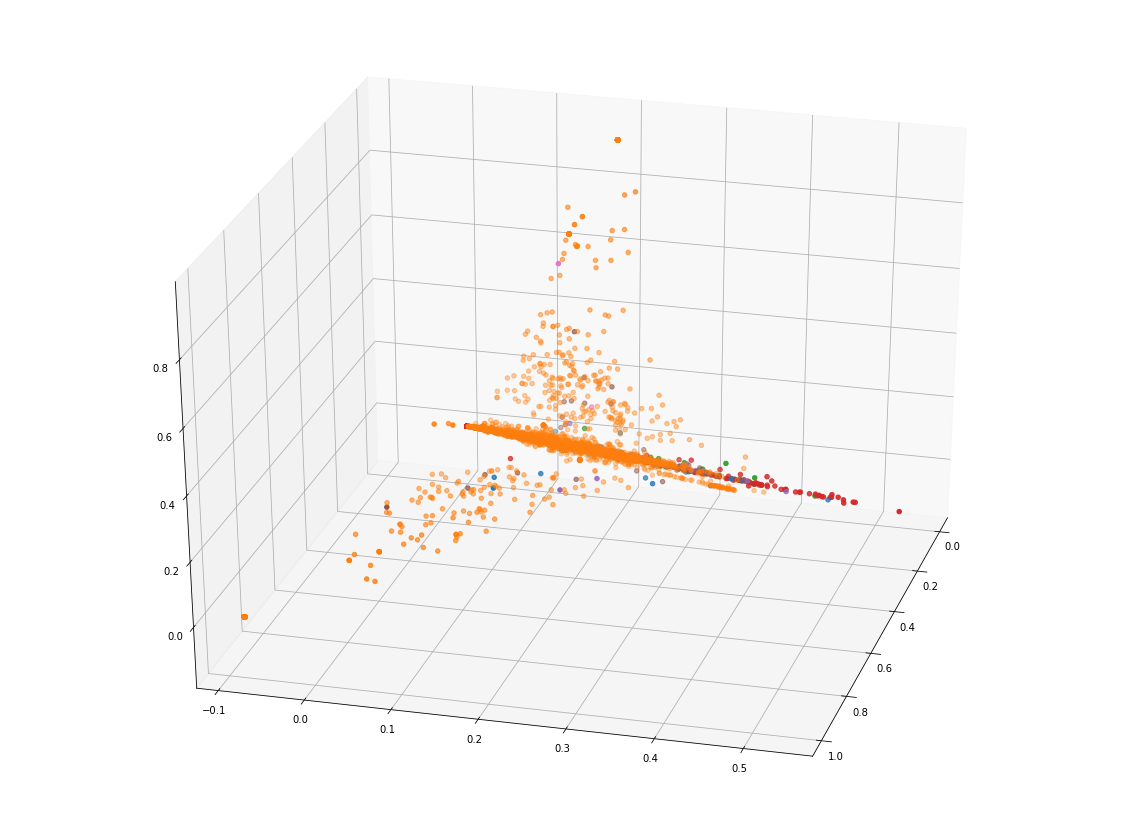

In [24]:
fig_size = [20, 15]
plt.rcParams["figure.figsize"] = fig_size

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for clusterIndex in range(0, clusterCount):
    svd_2d_cluster = np.array([np.array(svd_2d[i]) for i in range(0, len(svd_2d)) if clusterPredictions[i] == clusterIndex])
    x = svd_2d_cluster[:,0]
    y = svd_2d_cluster[:,1]
    z = svd_2d_cluster[:,2]
    ax.scatter(x, y, z)

ax.view_init(30, 15)
plt.show()

Как ни крути, тяжело разобрать, что происходит :(

### Попробуем погуглить и сделать что-то модное

Попробуем получше чистить тектсы на моменте tokenize

Штука, которая будет сбрасывать слова к их корню

In [25]:
stemmer = SnowballStemmer("english")

Будем бить на токены также, как раньше, но отфильтруем только слова (только с буквами) и сбросим к корню

In [26]:
def tokenizeAndStem(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

Сделаем Tf-idf, в этот раз мы подготовились сделать это правильно :)

In [27]:
newTfIdfVectorizer = TfidfVectorizer(max_df = 500, 
                                  max_features = 200000, 
                                  min_df = 10, 
                                  stop_words = 'english', 
                                  use_idf = True, 
                                  tokenizer = tokenizeAndStem, 
                                  ngram_range=(2,3))

tfidfMatrix = newTfIdfVectorizer.fit_transform(df['text'])

print(tfidfMatrix.shape)

(5414, 682)


In [28]:
terms = newTfIdfVectorizer.get_feature_names()

terms[:10]

["'d like",
 "'m copi",
 "'m sorri",
 "'m sure",
 "'m tri",
 "'m way",
 "'s best",
 "'s book",
 "'s comment",
 "'s confer"]

Кластеризация

In [29]:
newClusterCount = 30

km = KMeans(n_clusters = newClusterCount)
km.fit(tfidfMatrix)

clusters = km.labels_.tolist()

In [30]:
countOnClusters = [clusters.count(i) for i in range(0, newClusterCount)]
countOnClusters[:5]

[4495, 32, 97, 45, 19]

In [31]:
svd = TruncatedSVD(n_components=3).fit(tfidfMatrix)
svd_2d = svd.transform(tfidfMatrix)

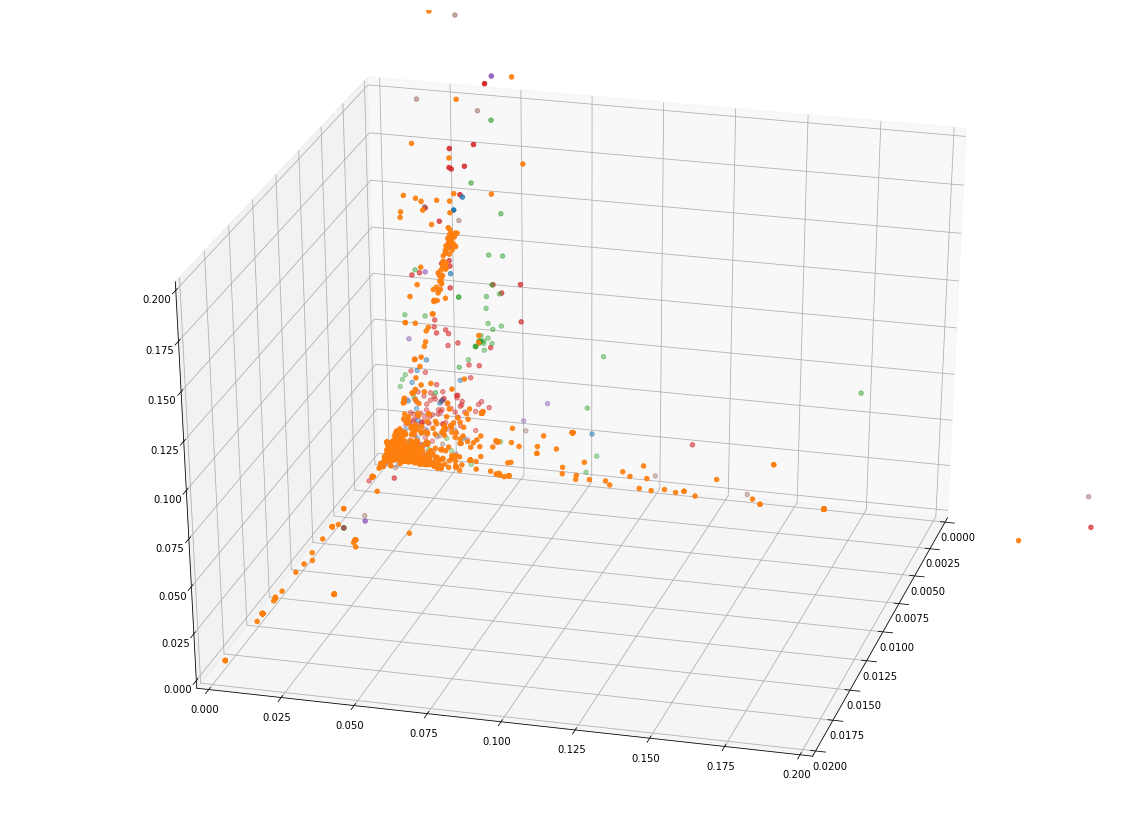

In [32]:
fig_size = [20, 15]
plt.rcParams["figure.figsize"] = fig_size

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for clusterIndex in range(0, clusterCount):
    svd_2d_cluster = np.array([np.array(svd_2d[i]) for i in range(0, len(svd_2d)) if clusterPredictions[i] == clusterIndex])
    x = svd_2d_cluster[:,0]
    y = svd_2d_cluster[:,1]
    z = svd_2d_cluster[:,2]
    ax.scatter(x, y, z)

ax.view_init(30, 15)
ax.set_xlim(0.0, 0.02)
ax.set_ylim(0.0, 0.2)
ax.set_zlim(0.0, 0.2)
plt.show()

Попробуем сделать ход конем и определить о чем каждый из кластеров. Для этого посмотрим на темы писем из каждого кластера. Чтобы отранжировать темы писем сделаем для них поиск наиболее частых биграм с помощью NLTK, а в качестве токенайзера возьмем нашу модную функцию привода к корню

In [33]:
subjectsOnClusters = []
for j in range(0, newClusterCount):
    subjectsOnClusters.append([subject for i, subject in enumerate(df['subject']) if clusters[i] == j])

In [34]:
subjectsBestBigarms = []
bigramMeasures = nltk.collocations.BigramAssocMeasures()
for j in range(0, newClusterCount):
    tokenizedWords = [tokenizeAndStem(subject) for subject in subjectsOnClusters[j]]
    finder = BigramCollocationFinder.from_documents(tokenizedWords)
    subjectsBestBigarms.append(finder.nbest(bigramMeasures.pmi, 10))
    
subjectsBestBigarms

[[('*after*', 'flight'),
  ('acclam', 'complet'),
  ('accompani', 'them'),
  ('amnesti', "int'l"),
  ('anecdot', 'attitudin'),
  ('anthoni', 'weiner'),
  ('anuncia', 'apoyo'),
  ('arb', 'panel'),
  ('arlen', 'specter'),
  ('asha', 'haji')],
 [('7pm', 'doe'),
  ('a', 'budget'),
  ('address', 'need'),
  ('agenda', 'per'),
  ('american', 'ideal'),
  ('and', 'steve'),
  ('bob', 'barnett'),
  ('boil', 'down'),
  ('child', 'traffick'),
  ('climat', 'change/copenhagen')],
 [('aid', 'dollar'),
  ('alfalfa', 'dinner'),
  ('all', 'prais'),
  ('american', 'friend'),
  ('approp', 'committe'),
  ('argentina', 'peru'),
  ('articl', 'w/'),
  ('audienc', 'research'),
  ('bbc', 'saddam'),
  ('bhutto', 'assassin')],
 [('again', 'here'),
  ('anoth', 'perspect'),
  ('ashton', 'meet'),
  ('bravo', 'brava'),
  ('dinner', 'tys'),
  ('edinburgh', 'film'),
  ('festiv', 'isra'),
  ('film', 'festiv'),
  ('final', 'pakistan'),
  ('follow', 'up')],
 [('activ', 'pend'),
  ('ambassador', 'susan'),
  ('as', 'sponsor'

Отсюда уже можно глазами начать делать какие-то выводы :)

1. Относится к событиям из Южной-Американского региона судя по заголовкам: Cuba, Bolivia и эксперту по внешней политике Shamila N. Chaudhar (спасибо, гугл)

2. К этому кластеру относится все подряд, некая помойка из писем, туда кластеризовалось большинство писем. Есть явный мусор вроде anecdot, но таже там много о санкциях против Авганистана (видимо, невереная классификация, может из-за того, что в заголовке фигурирует слеш ap/afghanistan)

3. Обсуждение вопрос бюджета (budget), планирования (agenda) и переписка с адвокатом семьи Клинтон, Robert Barnett

4. ...

5. Клинтон известна, как противник гей-браков, этот кластер посвящен данной теме (anti-gay)

6. ...

7. Часть посвящана обсуждению людей связанных с Клинтон, например Martin Torrey Commander, U.S. Navy (ret), забавно, но этот Мартин состоял в республиканской партии :)

8. ... (дальнейшие кластеры можно заполнить аналогично, гуглением по ключевикам, которые мы получили из кластеризации.)

Общая идея - Можно играть с количеством кластеров и пытаться наилучшим образом разбить письма. Но для понимания их сути лучше всего (что неудивительно) подходят заголовки писем. Они есть примерно у 3/4 всех писем. По ним легко можно понять, что большинство писем разделились по географическом признаку: Сирия, Либия, Афганистан, Куба, Боливия, Аргентина, Казахстан и т д.